In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# Reflecting an existing database into a new model
Base = automap_base()

# Reflecting tables
Base.prepare(engine, reflect=True)

In [7]:
# Viewing all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Saving references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Creating our session (link) from Python to the DB
session = Session(engine)

In [10]:
# Creating inspector and getting table names 
inspector = inspect(engine)

In [11]:
# Getting "measurement" table column names and types
measurement_columns = inspector.get_columns("measurement")
for column in measurement_columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [12]:
# Getting "station" table column names and types
station_columns = inspector.get_columns("station")
for column in station_columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Exploratory Climate Analysis

##### Designing a query to retrieve the last 12 months of precipitation data and plot the results


In [13]:
# Calculating the date 1 year ago from the last data point in the database

# --- Calculating last date in the DB
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]
# --- Transforming query to a time object
last_date_converted = (dt.datetime.strptime(last_date, "%Y-%m-%d")).date()
# --- Calculating last date in the DB - 1 year ago
year_ago = last_date_converted - dt.timedelta(days = 365)

In [14]:
# Performing a query to retrieve the date and precipitation scores
prcp = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= year_ago).\
    filter(Measurement.date <= last_date).\
    filter(Measurement.station == Station.station).all()

In [15]:
# Saving the query results as a Pandas DataFrame, setting the index to the date column and sorting by date
prcp_df = pd.DataFrame(prcp, columns = ["Date", "Precipitation"]).sort_values("Date")
prcp_df.set_index("Date", inplace = True)

# Droping null values 
prcp_df.dropna(axis = 0, how = "any", inplace = True)

# Printing final df 
prcp_df.head()

Precipitation
Date                     
2016-08-23           0.00
2016-08-23           1.79
2016-08-23           0.05
2016-08-23           0.15
2016-08-23           0.70

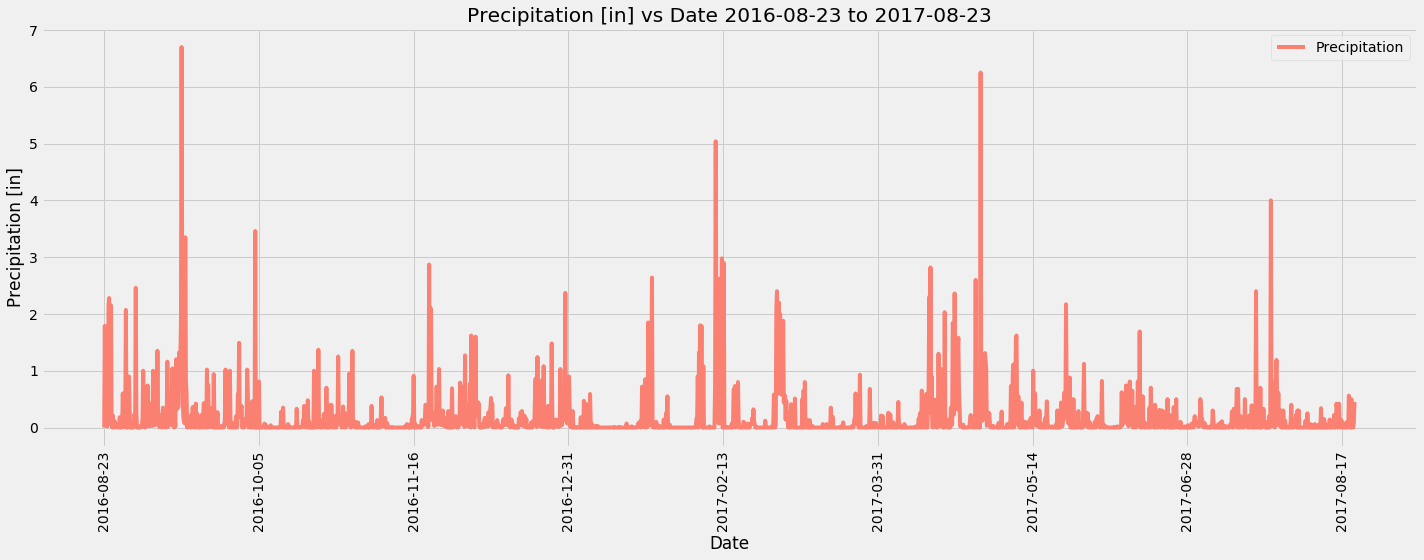

In [16]:
# Use Pandas Plotting with Matplotlib to plot the data
prcp_df.plot(figsize = (20, 8), rot = 90, color = "salmon")
plt.title(f"Precipitation [in] vs Date {year_ago} to {last_date}")
plt.ylabel("Precipitation [in]")
plt.xlabel("Date")
plt.tight_layout()
plt.show()

In [17]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_df.describe()

Precipitation
count    2021.000000
mean        0.177279
std         0.461190
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000

##### Station Analysis

In [18]:
# Design a query to show how many stations are available in this dataset?
number_of_stations = session.query(Station).count()
print(f"There are {number_of_stations} stations available in the dataset.")

There are 9 stations available in the dataset.


In [19]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
active_stations = session.query(Measurement.station, Station.name, func.count(Measurement.prcp)).\
    group_by(Station.name).\
    filter(Measurement.station == Station.station).\
    order_by(func.count(Measurement.prcp).desc()).all()

# Saving the query results as a Pandas DataFrame
active_stations_df = pd.DataFrame(active_stations, columns = ["Station ID", "Station Name", "Row Count"])
active_stations_df

Station ID                            Station Name  Row Count
0  USC00519281                     WAIHEE 837.5, HI US       2772
1  USC00513117                    KANEOHE 838.1, HI US       2696
2  USC00519397                    WAIKIKI 717.2, HI US       2685
3  USC00519523      WAIMANALO EXPERIMENTAL FARM, HI US       2572
4  USC00516128            MANOA LYON ARBO 785.2, HI US       2484
5  USC00514830  KUALOA RANCH HEADQUARTERS 886.9, HI US       1937
6  USC00511918       HONOLULU OBSERVATORY 702.2, HI US       1932
7  USC00517948                       PEARL CITY, HI US        683
8  USC00518838              UPPER WAHIAWA 874.3, HI US        342

In [20]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?

# --- Saving most active station as a variable
most_active_station = active_stations[0][0]

# --- USC00519281 Station Lowest Temperature Recorded 
lowest_temp = session.query(func.min(Measurement.tobs)).\
    filter(Measurement.station == most_active_station).scalar()

# --- USC00519281 Station Highest Temperature Recorded 
highest_temp = session.query(func.max(Measurement.tobs)).\
    filter(Measurement.station == most_active_station).scalar()

# --- USC00519281 Station Average Temperature Recorded 
avg_temp = session.query(func.avg(Measurement.tobs)).\
    filter(Measurement.station == most_active_station).scalar()

# --- Printing Results 
print(f"The lowest temperature recorded in the Station ID USC00519281 is: {lowest_temp} °F")
print(f"The highest temperature recorded in the Station ID USC00519281 is: {highest_temp} °F")
print(f"The average temperature recorded in the Station ID USC00519281 is: {round(avg_temp, 2)} °F")

The lowest temperature recorded in the Station ID USC00519281 is: 54.0 °F
The highest temperature recorded in the Station ID USC00519281 is: 85.0 °F
The average temperature recorded in the Station ID USC00519281 is: 71.66 °F


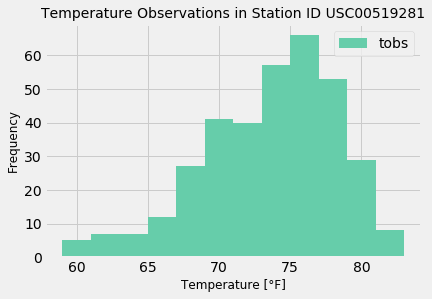

In [21]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
highest_obs_station = session.query(Measurement.tobs).\
    filter(Measurement.date >= year_ago).\
    filter(Measurement.station == most_active_station).all()

# --- Saving the query results as a Pandas DataFrame
highest_obs_station_df = pd.DataFrame(highest_obs_station, columns = ["Temperature"])

# --- Plotting data
plt.hist(highest_obs_station_df["Temperature"], bins = 12, color = "mediumaquamarine")
plt.title(f"Temperature Observations in Station ID {most_active_station}", size = 14)
plt.ylabel("Frequency", size = 12)
plt.xlabel("Temperature [°F]", size = 12)
plt.legend(["tobs"])
plt.show()

## Bonus Challenge Assignment

In [22]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [23]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

# --- Defining starting and ending dates
starting_date = dt.date(2014, 4, 25)
ending_date = dt.date(2014, 5, 1)

# --- Computing temperatures
func_result = calc_temps(starting_date, ending_date)

# --- Printing Results
print(func_result)

[(63.0, 70.82978723404256, 80.0)]


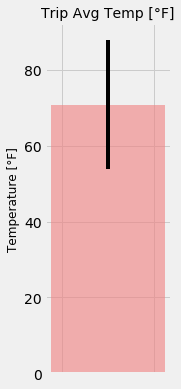

In [24]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

tmin = func_result[0][0]
tavg = func_result[0][1]
tmax = func_result[0][2]

# --- Calculating yerror value (tmax-tim)
yerror = tmax - tmin

# --- Generating plot 
plt.figure(figsize = (2, 6))
plt.bar(1, height = tavg, yerr = yerror, width = 2.5, color = "lightcoral", alpha = 0.60)
plt.title("Trip Avg Temp [°F]", size = 14)
plt.ylabel("Temperature [°F]", size = 12)
plt.tick_params(labelbottom = False)
plt.show()

## Daily Rainfall Average

In [25]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

# --- Defining previous year's matching dates
starting_year_ago = starting_date - dt.timedelta(days=365)
ending_year_ago = ending_date - dt.timedelta(days=365)

# --- Querying data
rainfall = session.query(Measurement.station, Station.name, Station.latitude, Station.longitude, Station.elevation, func.sum(Measurement.prcp)).\
    group_by(Station.name).\
    filter(Measurement.station == Station.station).\
    filter(Measurement.date >= starting_year_ago).\
    filter(Measurement.date <= ending_year_ago).\
    order_by(func.sum(Measurement.prcp).desc()).all()

# Saving the query results as a Pandas DataFrame
rainfall_df = pd.DataFrame(rainfall, columns = ["Station ID", "Station Name", "Latitude", "Longitude", "Elevation", "Total Precipitation"])

rainfall_df

Station ID                            Station Name  Latitude  Longitude  \
0  USC00516128            MANOA LYON ARBO 785.2, HI US  21.33310 -157.80250   
1  USC00519281                     WAIHEE 837.5, HI US  21.45167 -157.84889   
2  USC00513117                    KANEOHE 838.1, HI US  21.42340 -157.80150   
3  USC00517948                       PEARL CITY, HI US  21.39340 -157.97510   
4  USC00511918       HONOLULU OBSERVATORY 702.2, HI US  21.31520 -157.99920   
5  USC00519397                    WAIKIKI 717.2, HI US  21.27160 -157.81680   
6  USC00514830  KUALOA RANCH HEADQUARTERS 886.9, HI US  21.52130 -157.83740   
7  USC00519523      WAIMANALO EXPERIMENTAL FARM, HI US  21.33556 -157.71139   

   Elevation  Total Precipitation  
0      152.4                 1.24  
1       32.9                 0.99  
2       14.6                 0.98  
3       11.9                 0.18  
4        0.9                 0.02  
5        3.0                 0.01  
6        7.0                 0.01  
7       19.5                 0.00

In [26]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [27]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Setting the start and end date of the trip
starting_date = dt.date(2014, 4, 25)
ending_date = dt.date(2014, 5, 1)

# Using the start and end date to create a range of dates
range_of_dates = []
strt_date = starting_date

while strt_date <= ending_date:
    month = strt_date.strftime("%m")
    day = strt_date.strftime('%d')
    range_of_dates.append(f"{month}-{day}")
    strt_date += dt.timedelta(days=1)
    
# Looping through the list of %m-%d strings and calculating the normals for each date
normals = []

for x in range(len(range_of_dates)):
    day_normal = daily_normals(range_of_dates[x])
    normals.append(day_normal[0])

In [28]:
# Loading the previous query results into a Pandas DataFrame and adding the `trip_dates` range as the `date` index
normals_df = pd.DataFrame(normals, columns = ["tmin", "tavg", "tmax"])
normals_df["Date"] = range_of_dates
normals_df.set_index("Date", inplace = True)
normals_df                     

tmin       tavg  tmax
Date                        
04-25  66.0  73.965517  83.0
04-26  66.0  74.017241  81.0
04-27  65.0  72.872727  81.0
04-28  63.0  73.464286  79.0
04-29  66.0  73.303571  81.0
04-30  58.0  71.557692  78.0
05-01  65.0  72.759259  79.0

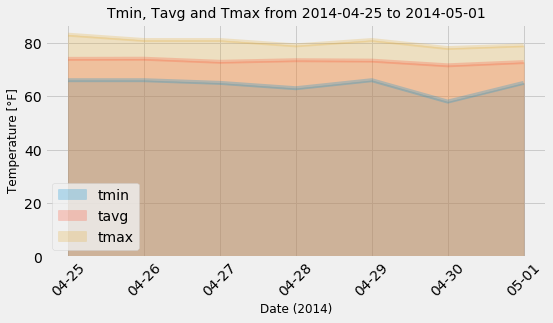

In [29]:
# Plotting the daily normals as an area plot with `stacked=False`
normals_df.plot.area(stacked = False, alpha = 0.25, rot = 45, figsize = (8, 4))
plt.title(f"Tmin, Tavg and Tmax from {starting_date} to {ending_date}", size = 14)
plt.ylabel("Temperature [°F]", size = 12)
plt.xlabel("Date (2014)", size = 12)
plt.show()